# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
#!pip install gensim



In [2]:
#!pip install pyLDAvis==3.4.1 --user

In [3]:
!#pip install pyLDAvis --upgrade --user


In [29]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
#import pyLDAvis.sklearn
import gensim
from gensim import corpora

import pyLDAvis.gensim_models as gensimvis

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# add any additional libaries you need here
import nltk
from nltk.corpus import brown, stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords




nltk.download('brown')
nltk.download('punkt')

nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [7]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [8]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [9]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


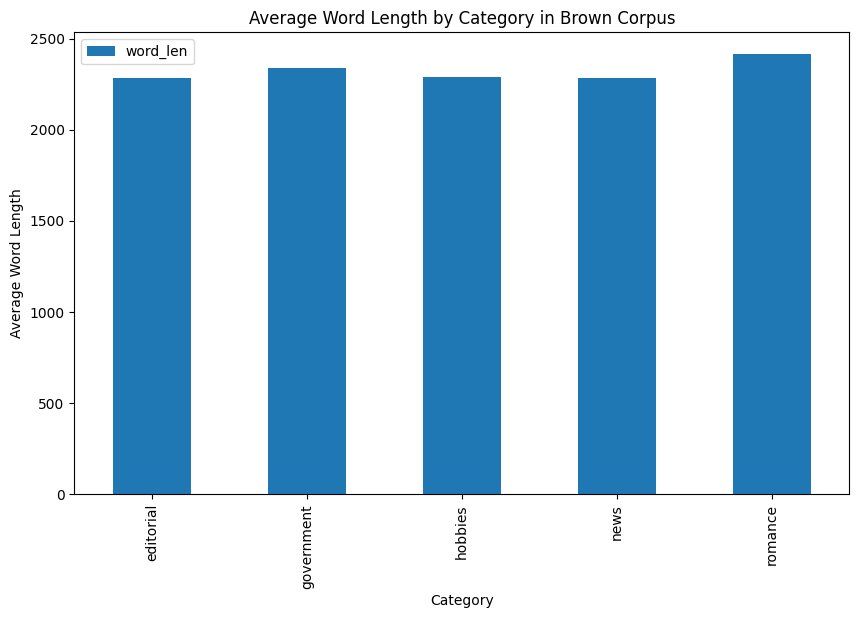

In [12]:
# Plot the average word length by category
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))
plt.xlabel('Category')
plt.ylabel('Average Word Length')
plt.title('Average Word Length by Category in Brown Corpus')
plt.show()

Now do our TF-IDF and Count vectorizations.

In [15]:
# Define stopwords
stopwords = set(stopwords.words('english'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Perform Count Vectorization

count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
print(count_text_vectors.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 5073)


In [17]:
# Perform TF-IDF Vectorization
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
print(tfidf_text_vectors.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 5073)


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: count_text_vectors: This matrix represents the count of terms in the text documents, where each row corresponds to a document and each column corresponds to a unique term. The values in the matrix indicate the number of times each term appears in each document. It has 166 rows (documents) and 5073 columns (unique terms).
tfidf_text_vectors: This matrix represents the TF-IDF (Term Frequency-Inverse Document Frequency) scores for the terms in the text documents. Each row corresponds to a document, and each column corresponds to a unique term. The values in the matrix indicate the importance of each term in a document relative to the entire corpus. It also has 166 rows and 5073 columns, representing the same documents and terms as in the count matrix but with TF-IDF scores instead of raw counts.
Both matrices are sparse representations of the text data, with most values being zero due to the large number of unique terms relative to the number of documents.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [18]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [20]:
# Your code here
# Step 1: Assign each document to its most prominent topic
df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

# Step 2: Tally the Brown categories for each topic
tally = pd.crosstab(df['nmf_topic'], df['category'])

# Display the tally
print(tally)

# Step 3: Interpret the results
# For each topic, list the most common categories
for topic in range(nmf_text_model.n_components):
    print(f"\nTopic {topic} is most associated with the following categories:")
    print(tally.loc[topic].sort_values(ascending=False))

category   editorial  government  hobbies  news  romance
nmf_topic                                               
0                 21           5        1     8        0
1                  5           0       10     0       29
2                  0           0        1    18        0
3                  1          25       22     9        0
4                  0           0        2     9        0

Topic 0 is most associated with the following categories:
category
editorial     21
news           8
government     5
hobbies        1
romance        0
Name: 0, dtype: int64

Topic 1 is most associated with the following categories:
category
romance       29
hobbies       10
editorial      5
government     0
news           0
Name: 1, dtype: int64

Topic 2 is most associated with the following categories:
category
news          18
hobbies        1
editorial      0
government     0
romance        0
Name: 2, dtype: int64

Topic 3 is most associated with the following categories:
category
governme

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic NMF model compare to the original Brown categories?

A:
The five-topic NMF model shows varying alignment with the original Brown categories:
Topic 0: Primarily aligns with 'editorial' and includes 'news' and 'government.'
Topic 1: Strongly associated with 'romance,' with some 'hobbies' content.
Topic 2: Identifies 'news' articles.
Topic 3: Mixes 'government' and 'hobbies' themes.
Topic 4: Mostly related to 'news.'
Overall, the NMF model effectively identifies significant themes, with some overlap in categories like 'editorial' and 'news' while clearly distinguishing 'romance.' It captures broader themes spanning multiple categories, indicating a good but not perfect alignment.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [21]:
# Your code here
#Fit the LSA Model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
lsa_W_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
lsa_H_text_matrix = lsa_text_model.components_


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Display the Topics
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())



Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.90)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.51)
  mr (1.91)
  said (1.47)
  jr (0.88)
  jury (0.85)

Topic 03
  khrushchev (3.00)
  berlin (2.38)
  soviet (2.25)
  kennedy (2.25)
  laos (2.07)

Topic 04
  game (4.95)
  league (3.55)
  baseball (3.47)
  ball (3.36)
  team (3.18)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Assign each document to its most prominent topic
df['lsa_topic'] = np.argmax(lsa_W_text_matrix, axis=1)

# Tally the Brown categories for each topic
lsa_tally = pd.crosstab(df['lsa_topic'], df['category'])

# Display the tally
print(lsa_tally)

# Interpret the results
# For each topic, list the most common categories
for topic in range(lsa_text_model.n_components):
    print(f"\nTopic {topic} is most associated with the following categories:")
    print(lsa_tally.loc[topic].sort_values(ascending=False))


category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          30       36    33       25
1                  0           0        0     0        4
2                  0           0        0     3        0
3                  0           0        0     1        0
4                  0           0        0     7        0

Topic 0 is most associated with the following categories:
category
hobbies       36
news          33
government    30
editorial     27
romance       25
Name: 0, dtype: int64

Topic 1 is most associated with the following categories:
category
romance       4
editorial     0
government    0
hobbies       0
news          0
Name: 1, dtype: int64

Topic 2 is most associated with the following categories:
category
news          3
editorial     0
government    0
hobbies       0
romance       0
Name: 2, dtype: int64

Topic 3 is most associated with the following categories:
category
news          1
ed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic LSA model compare to the original Brown categories?

A: The five-topic LSA model shows significant overlap between all categories for Topic 0, which captures most documents across all categories—topics 1 through 4 show minimal alignment with the original categories, indicating a poor separation of themes.
Topic 0: Includes documents from all categories showing substantial overlap.
Topic 1: Minor association with 'romance' (4 articles).
Topic 2: Minor association with 'news' (3 articles).
Topic 3: Minor association with 'news' (1 article).
Topic 4: Minor association with 'news' (7 articles).


Q: What is your interpretation of the display topics output?

A: The display topics output reveals that:
Topic 0: It is broad and captures diverse terms, indicating it needs to be well-differentiated.
Topic 1: Focuses on terms related to 'romance'.
Topic 2 to 4: These topics capture terms related to 'news' and must be better differentiated.
The LSA model must effectively distinguish between the categories, as most documents and terms cluster into a single topic. This suggests that the LSA model may be less effective than NMF in capturing distinct themes from the Brown corpus.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [27]:
# Fit your LDA model here
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())




Topic 00
  may (0.89)
  state (0.87)
  states (0.73)
  use (0.57)
  united (0.54)

Topic 01
  mrs (1.37)
  feed (0.70)
  per (0.49)
  house (0.44)
  pool (0.41)

Topic 02
  mr (0.60)
  president (0.51)
  american (0.44)
  world (0.42)
  united (0.40)

Topic 03
  said (1.31)
  state (0.60)
  000 (0.54)
  business (0.54)
  sales (0.44)

Topic 04
  said (1.24)
  back (0.60)
  old (0.50)
  little (0.49)
  man (0.45)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Visualize the LDA Model using pyLDAvis
# Convert the count matrix to a gensim corpus
corpus = gensim.matutils.Sparse2Corpus(count_text_vectors, documents_columns=False)
id_map = dict((v, k) for k, v in count_text_vectorizer.vocabulary_.items())

# Create a gensim dictionary
dictionary = corpora.Dictionary.from_corpus(corpus, id_map)

# Fit the LDA model using gensim
lda_gensim_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=314)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What inference do you draw from the displayed topics for your LDA model?

A:
The Latent Dirichlet Allocation (LDA) model, a popular tool in topic modeling and natural language processing, has generated five topics with distinct thematic focuses:
Topic 00: This topic centers around government and policy discussions, with critical terms like "may," "state," "states," "use," and "united." It clearly focuses on governmental themes.
Topic 01: Terms such as "mrs," "feed," "per," "house," and "pool" indicate a theme related to domestic life and household activities.
Topic 02: Focuses on political and international affairs with terms like "mr," "president," "american," "world," and "united."
Topic 03: Economic and business discussions are highlighted with terms like "said," "state," "000," "business," and "sales."
Topic 04: This topic appears to capture more general narratives, potentially personal stories or anecdotes, with terms like "said," "back," "old," "little," and "man."
Overall, the topics are distinct, but some standard terms like "said" appear across multiple topics, indicating frequently used words in the corpus.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: Topic 00: Strongly aligned with 'government' and 'hobbies', clearly identifying themes related to government policy and recreational activities.
Topic 01: Contains a mix of 'hobbies' and 'news', showing the overlap in domestic life and public activities.
Topic 02: Dominated by 'editorial', 'government', and 'news', suggesting a blend of political and editorial themes.
Topic 03: Primarily 'news', with some 'government' content highlighting economic and business news.
Topic 04: Strongly associated with 'romance', clearly identifying themes related to personal stories and relationships.
Overall, the LDA model captures the main themes within the Brown corpus, with some topics clearly aligning with specific categories. This demonstrates the model's effectiveness in distinguishing between different thematic areas, although further tuning could improve the separation and clarity of topics.



In [33]:
# Get the topic distribution for each document using LDA
document_topics_lda = lda_model.transform(count_text_vectors)

# Assign each document to the most prominent LDA topic
df['lda_topic'] = document_topics_lda.argmax(axis=1)

# Tally the Brown categories for each topic
topic_category_tally_lda = pd.crosstab(df['lda_topic'], df['category'])

# Display the tally
print(topic_category_tally_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  0          15       11     0        0
1                  1           1       10     5        0
2                 22           9        8    14        0
3                  0           5        2    17        0
4                  4           0        5     8       29


In [31]:
lda_display = gensimvis.prepare(lda_gensim_model, corpus, dictionary)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
pyLDAvis.display(lda_display)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The principal component scatterplot shows the similarities and differences between topics. Topics close together are similar, while those farther apart are different. The circle size indicates the relevance of each topic. In the chart, topics 9 and 6 are far apart, suggesting they are different, but both have large circles, indicating high relevance in the corpus.
The salient terms graph highlights the most important words for each topic. For instance, terms like "state," "united," "states," and "government" dominate topic 9, suggesting a government-related theme. Topic 6 features different terms, likely indicating themes such as editorial or romance.
Overall, the visualization effectively shows topics' distinctiveness and relevance, helping to classify and understand the themes in the corpus.

In [34]:
from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [35]:
!jupyter nbconvert --to html '/content/drive/MyDrive/USD/SUMMER_2024/Module_5/Topic Modeling.ipynb'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[NbConvertApp] Converting notebook /content/drive/MyDrive/USD/SUMMER_2024/Module_5/Topic Modeling.ipynb to html
[NbConvertApp] Writing 766727 bytes to /content/drive/MyDrive/USD/SUMMER_2024/Module_5/Topic Modeling.html


In [38]:
#!pip install nbconvert pdfkit
#!apt-get install wkhtmltopdf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
import pdfkit

input_file = '/content/drive/MyDrive/USD/SUMMER_2024/Module_5/Topic Modeling.html'
output_file = '/content/drive/MyDrive/USD/SUMMER_2024/Module_5/Topic Modeling.pdf'

pdfkit.from_file(input_file, output_file)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True